# Supervised Learning (Classification)

In supervised learning, the task is to infer hidden structure from
labeled data, comprised of training examples $\{(x_n, y_n)\}$.
Classification means the output $y$ takes discrete values.

We demonstrate with an example in Edward. A webpage version is available at
http://edwardlib.org/tutorials/supervised-classification.

In [51]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs

## Data

Use the
[crabs data set](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/crabs.html),
which consists of morphological measurements on a crab species. We
are interested in predicting whether a given crab has the color form
blue (encoded as 0) or orange (encoded as 1). We use all the numeric features
in the dataset.

In [3]:
ed.set_seed(42)

data, metadata = crabs("~/data")
X_train = data[:100, 3:]
y_train = data[:100, 1]

X_test = data[100:200, 3:]
y_test = data[100:200, 1]

N = X_train.shape[0]  # number of data points
D = X_train.shape[1]  # number of features

print("Number of data points: {}".format(N))
print("Number of features: {}".format(D))

Number of data points: 100
Number of features: 5


## Model

A Gaussian process is a powerful object for modeling nonlinear
relationships between pairs of random variables. It defines a distribution over
(possibly nonlinear) functions, which can be applied for representing
our uncertainty around the true functional relationship.
Here we define a Gaussian process model for classification
(Rasumussen & Williams, 2006).

Formally, a distribution over functions $f:\mathbb{R}^D\to\mathbb{R}$ can be specified
by a Gaussian process
$$
\begin{align*}
  p(f)
  &=
  \mathcal{GP}(f\mid \mathbf{0}, k(\mathbf{x}, \mathbf{x}^\prime)),
\end{align*}
$$
whose mean function is the zero function, and whose covariance
function is some kernel which describes dependence between
any set of inputs to the function.

Given a set of input-output pairs
$\{\mathbf{x}_n\in\mathbb{R}^D,y_n\in\mathbb{R}\}$,
the likelihood can be written as a multivariate normal

\begin{align*}
  p(\mathbf{y})
  &=
  \text{Normal}(\mathbf{y} \mid \mathbf{0}, \mathbf{K})
\end{align*}

where $\mathbf{K}$ is a covariance matrix given by evaluating
$k(\mathbf{x}_n, \mathbf{x}_m)$ for each pair of inputs in the data
set.

The above applies directly for regression where $\mathbb{y}$ is a
real-valued response, but not for (binary) classification, where $\mathbb{y}$
is a label in $\{0,1\}$. To deal with classification, we interpret the
response as latent variables which is squashed into $[0,1]$. We then
draw from a Bernoulli to determine the label, with probability given
by the squashed value.

Define the likelihood of an observation $(\mathbf{x}_n, y_n)$ as

\begin{align*}
  p(y_n \mid \mathbf{z}, x_n)
  &=
  \text{Bernoulli}(y_n \mid \text{logit}^{-1}(\mathbf{x}_n^\top \mathbf{z})).
\end{align*}

Define the prior to be a multivariate normal

\begin{align*}
  p(\mathbf{z})
  &=
  \text{Normal}(\mathbf{z} \mid \mathbf{0}, \mathbf{K}),
\end{align*}

with covariance matrix given as previously stated.

Let's build the model in Edward. We use a radial basis function (RBF)
kernel, also known as the squared exponential or exponentiated
quadratic. It returns the kernel matrix evaluated over all pairs of
data points; we then Cholesky decompose the matrix to parameterize the
multivariate normal distribution.

In [32]:
X = tf.placeholder(tf.float32, [N, D])
f = MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X)))
y = Bernoulli(logits=f)

Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

## Inference

Perform variational inference.
Define the variational model to be a fully factorized normal.

In [33]:
qf = Normal(loc=tf.Variable(tf.random_normal([N])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

Run variational inference for `500` iterations.

In [35]:
inference = ed.KLqp({f: qf}, data={X: X_train, y: y_train})
inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 82.407


<ed.RandomVariable 'Bernoulli_14/' shape=(100,) dtype=int32>

In this case
`KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](/tutorials/klqp).
(This example happens to be slow because evaluating and inverting full
covariances in Gaussian processes happens to be slow.)

## Evaluation

In [48]:
y_post = ed.copy(y, {f: qf})
print("Mean squared error on test data:")
# change the datatype
y_post = tf.cast(y_post, tf.float32)
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.126251


## Visualization

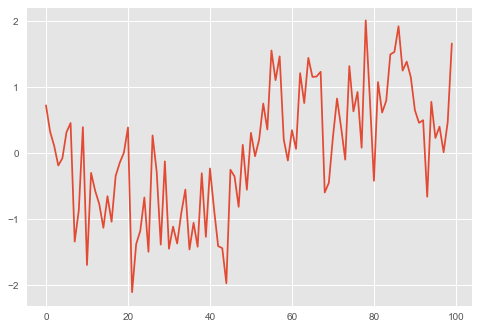

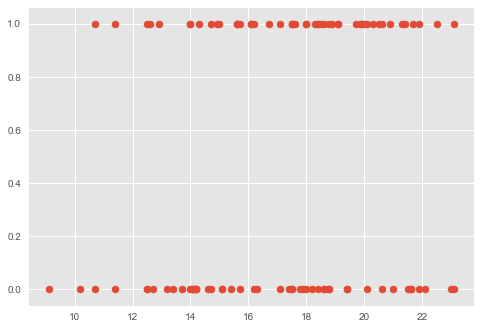

In [77]:
f_samples = qf.sample(10).eval()
plt.plot(f_samples[1])
plt.figure()
plt.scatter(X_test[:, 0], y_test)

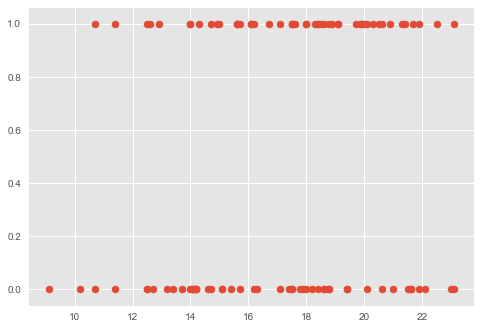